In [1]:
cd ../TileEM/

/srv/data/home/jlee782/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from paper_visualizations import * 
from PixelEM import * 
from test_sample import test_sample_obj
import json
import pandas as pd
object_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47]

Populating the interactive namespace from numpy and matplotlib


In [3]:
tile_df = pd.read_csv("tile_greedy_algos_performance.csv")
pixel_df = pd.read_csv("pixel_greedy_algos_performance.csv")

```
The following are some of the things you could look at:
1) average and top jaccards
2) performance on hard and easy objects
3) performance as it varies with number of workers
4) correlation b/w estimated and actual jaccard
5) performance when estimated jaccard is high (and does performance for low estimated jaccard improve when you increase the number of workers)
```

In [85]:
from sklearn import linear_model
from scipy.stats.stats import pearsonr
from collections import defaultdict
def read_all_performance_info(wqual_model_list, sort_order,PixOrT):
    # only do this for one specified sort_order at a time
    print 'Reading all performance info...'
    performance_info = dict()
    wqual_model_list = ['gt_aware'] + wqual_model_list
    with open('{}_greedy_algos_performance.csv'.format(PixOrT), 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            batch = row['batch']
            objid = int(row['objid'])
            if batch not in performance_info:
                performance_info[batch] = dict()
            if objid not in performance_info[batch]:
                performance_info[batch][objid] = dict()
                for wqual_model in wqual_model_list:
                    performance_info[batch][objid][wqual_model] = dict()

            for wqual_model in wqual_model_list:
                est_jacc_field = 'est_jacc ({},{})'.format(wqual_model, sort_order)
                act_jacc_field = 'act_jacc ({},{})'.format(wqual_model, sort_order)
                performance_info[batch][objid][wqual_model]['est_jacc'] = float(row[est_jacc_field])
                performance_info[batch][objid][wqual_model]['act_jacc'] = float(row[act_jacc_field])
    print 'Done'
    return performance_info


def analyze_all_performance_info(wqual_model_list, sort_order,PixOrT):
    # only do this for one specified sort_order at a time
    performance_info = read_all_performance_info(wqual_model_list, sort_order,PixOrT)

    wqual_model_list = ['gt_aware'] + wqual_model_list

    performance_on_num_workers = defaultdict(lambda: defaultdict(list))  # performance_on_batch[num_workers][wqual_model] = list()
    performance_on_object = defaultdict(lambda: defaultdict(list))  # performance_on_batch[object][wqual_model] = list()
    performance_on_all = defaultdict(list)  # performance_on_all = list()
    est_performance_on_all = defaultdict(list)  # for correlation b/w est performance and actual performance

    performance_on_high_est_jacc_all = defaultdict(list)
    performance_on_high_est_jacc_num_workers = defaultdict(lambda: defaultdict(list))

    for batch in performance_info:
        num_workers = int(batch.split('w')[0])
        for objid in performance_info[batch]:
            for wqual_model in wqual_model_list:
                est_jacc = performance_info[batch][objid][wqual_model]['est_jacc']
                act_jacc = performance_info[batch][objid][wqual_model]['act_jacc']
                performance_on_num_workers[num_workers][wqual_model].append(act_jacc)
                performance_on_object[objid][wqual_model].append(act_jacc)
                performance_on_all[wqual_model].append(act_jacc)
                est_performance_on_all[wqual_model].append(est_jacc)

                # testing if high estimate
                # currently use mv_weighted for it
                if 'mv_weighted' in wqual_model_list and \
                        performance_info[batch][objid]['mv_weighted']['est_jacc'] > 0.8:
                    performance_on_high_est_jacc_all[wqual_model].append(act_jacc)
                    performance_on_high_est_jacc_num_workers[num_workers][wqual_model].append(act_jacc)

    print '--------------------------------------------------------------'
    print 'Performance across all {batches x objects}'
    for wqual_model in performance_on_all:
        avg = numpy.mean(performance_on_all[wqual_model])
        med = numpy.median(performance_on_all[wqual_model])
        print '{}: mean = {}, median = {}'.format(wqual_model, round(avg, 5), round(med, 5))

    print '--------------------------------------------------------------'
    print 'Performance on high jacc estimate {batches x objects}'
    for wqual_model in performance_on_high_est_jacc_all:
        avg = numpy.mean(performance_on_high_est_jacc_all[wqual_model])
        med = numpy.median(performance_on_high_est_jacc_all[wqual_model])
        print '{}: mean = {}, median = {}'.format(wqual_model, round(avg, 5), round(med, 5))

    print '--------------------------------------------------------------'
    print 'Performance split on number of workers'
    for num_workers in performance_on_num_workers:
        performance_dict = dict()
        for wqual_model in performance_on_num_workers[num_workers]:
            avg = numpy.mean(performance_on_num_workers[num_workers][wqual_model])
            performance_dict[wqual_model] = round(avg, 5)
        print '{}: {}'.format(num_workers, performance_dict)

    print '--------------------------------------------------------------'
    print 'Performance split on number of workers, for only high jacc estimatae {batches x objects}'
    for num_workers in performance_on_high_est_jacc_num_workers:
        performance_dict = dict()
        for wqual_model in performance_on_high_est_jacc_num_workers[num_workers]:
            avg = numpy.mean(performance_on_high_est_jacc_num_workers[num_workers][wqual_model])
            performance_dict[wqual_model] = round(avg, 5)
        print '{}: {}'.format(num_workers, performance_dict)

    print '--------------------------------------------------------------'

    # correlation b/w est and actual
    print 'Testing correlation b/w estimated and actual jaccard values'
    for wqual_model in wqual_model_list:
        est_vals = est_performance_on_all[wqual_model]
        act_vals = performance_on_all[wqual_model]
        corr_coefficient = pearsonr(est_vals, act_vals)
        print '{}: {}'.format(wqual_model, corr_coefficient)
        if wqual_model == 'mv_weighted':
            plot_linear_fit(est_vals, act_vals,"Estimated Jaccard","Actual Jaccard")
            # plt.show()
            #plt.savefig(MATERIALIZED_DATA_DIR + 'mv_weighted_est_vs_act_jacc.png')
            #plt.close()
    print '--------------------------------------------------------------'
    est_mv = est_performance_on_all['mv_weighted']
    act_isogt = performance_on_all['isoGT']
    print 'Corr of est_mv_weighted against act_isoGT: ', pearsonr(est_mv, act_isogt)
    plot_linear_fit(est_mv,act_isogt,"est_mv weighted","act_isogt")
    return est_mv, act_isogt

In [92]:
def plot_linear_fit(x,y,xName,yName):
    plt.figure()
    plt.title("Pearson's R={:.2f}".format(pearsonr(x,y)[0]))
    regr = linear_model.LinearRegression()
    x=np.array([x])
    y = np.array([y])
    regr.fit(x.T,y.T)

    plt.xlabel(xName,fontsize=13)
    plt.ylabel(yName,fontsize=13)
    plt.plot(x,y, 'o',color='blue')
    plt.plot(x.T, regr.predict(x.T),color="red", linewidth=3)

Reading all performance info...
Done
--------------------------------------------------------------
Performance across all {batches x objects}
GT: mean = 0.89313, median = 0.91307
mv: mean = 0.88979, median = 0.91465
mv_weighted: mean = 0.88312, median = 0.91233
gt_aware: mean = 0.97352, median = 0.98063
isoGT: mean = 0.91168, median = 0.92394
--------------------------------------------------------------
Performance on high jacc estimate {batches x objects}
GT: mean = 0.90815, median = 0.92837
mv: mean = 0.90883, median = 0.92784
mv_weighted: mean = 0.90831, median = 0.92802
gt_aware: mean = 0.97775, median = 0.98495
isoGT: mean = 0.92567, median = 0.93749
--------------------------------------------------------------
Performance split on number of workers
5: {'mv': 0.88153, 'GT': 0.87562, 'mv_weighted': 0.88037, 'gt_aware': 0.9552, 'isoGT': 0.91858}
10: {'mv': 0.89327, 'GT': 0.8925, 'mv_weighted': 0.88021, 'gt_aware': 0.96422, 'isoGT': 0.916}
15: {'mv': 0.89801, 'GT': 0.89993, 'mv_we

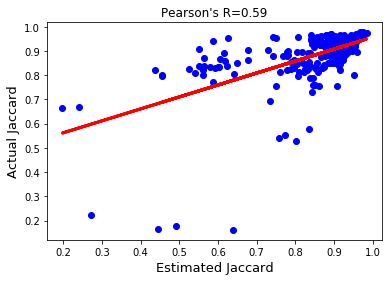

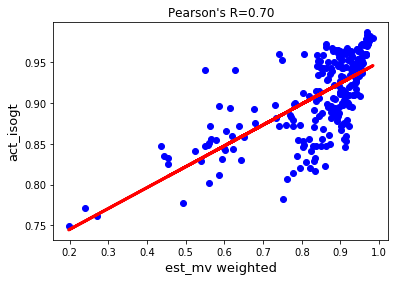

In [93]:
wqual_model_list = ['mv', 'mv_weighted', 'GT', 'isoGT']
sort_order_list = ['i_by_o', 'i_by_o_times_a']
est_mv, act_isogt = analyze_all_performance_info(wqual_model_list, 'i_by_o',PixOrT='pixel')

In [104]:
df = pixel_df

In [105]:
df.filter(regex="act_jacc").mean()

act_jacc (gt_aware,i_by_o)               0.973519
act_jacc (mv,i_by_o)                     0.889788
act_jacc (mv_weighted,i_by_o)            0.883118
act_jacc (GT,i_by_o)                     0.893129
act_jacc (isoGT,i_by_o)                  0.911679
act_jacc (gt_aware,i_by_o_times_a)       0.973519
act_jacc (mv,i_by_o_times_a)             0.889788
act_jacc (mv_weighted,i_by_o_times_a)    0.880042
act_jacc (GT,i_by_o_times_a)             0.893129
act_jacc (isoGT,i_by_o_times_a)          0.911674
dtype: float64

### Performance as it varies with number of workers

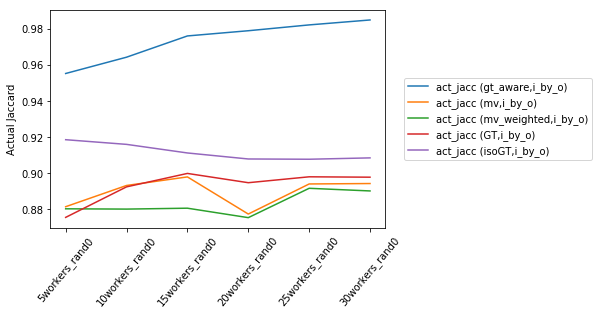

In [187]:
i_by_o = [u'act_jacc (gt_aware,i_by_o)', u'act_jacc (mv,i_by_o)',u'act_jacc (mv_weighted,i_by_o)', u'act_jacc (GT,i_by_o)',u'act_jacc (isoGT,i_by_o)']
i_by_o_times_a = [u'act_jacc (gt_aware,i_by_o_times_a)',u'act_jacc (mv,i_by_o_times_a)',u'act_jacc (mv_weighted,i_by_o_times_a)',u'act_jacc (GT,i_by_o_times_a)', u'act_jacc (isoGT,i_by_o_times_a)']
Nworker_performance = df.groupby("batch").mean().filter(regex="act_jacc")[i_by_o]
Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in Nworker_performance.columns:
    plt.plot(np.array(Nworker_performance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Actual Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])

In [188]:
Nworker_performance

,"act_jacc (gt_aware,i_by_o)","act_jacc (mv,i_by_o)","act_jacc (mv_weighted,i_by_o)","act_jacc (GT,i_by_o)","act_jacc (isoGT,i_by_o)"
batch,,,,,
5workers_rand0,0.955200,0.881528,0.880365,0.875624,0.918583
10workers_rand0,0.964218,0.893270,0.880207,0.892504,0.916003
15workers_rand0,0.975970,0.898008,0.880703,0.899932,0.911250
20workers_rand0,0.978850,0.877472,0.875479,0.894802,0.907925
25workers_rand0,0.982075,0.894107,0.891709,0.898064,0.907781
30workers_rand0,0.984803,0.894345,0.890245,0.897851,0.908530


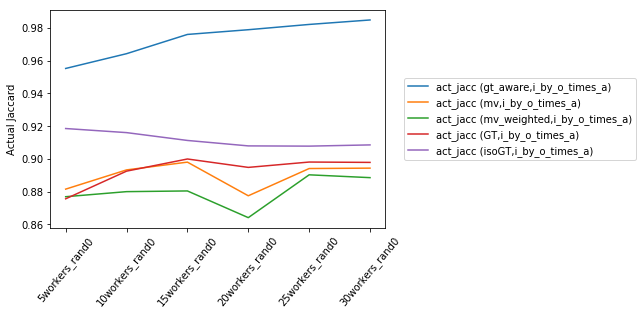

In [185]:
Nworker_performance = df.groupby("batch").mean().filter(regex="act_jacc")[i_by_o_times_a]
Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in Nworker_performance.columns:
    plt.plot(np.array(Nworker_performance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Actual Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])

In [186]:
Nworker_performance

,"act_jacc (gt_aware,i_by_o_times_a)","act_jacc (mv,i_by_o_times_a)","act_jacc (mv_weighted,i_by_o_times_a)","act_jacc (GT,i_by_o_times_a)","act_jacc (isoGT,i_by_o_times_a)"
batch,,,,,
5workers_rand0,0.955200,0.881528,0.876902,0.875624,0.918528
10workers_rand0,0.964218,0.893270,0.879996,0.892504,0.916033
15workers_rand0,0.975970,0.898008,0.880423,0.899932,0.911250
20workers_rand0,0.978850,0.877472,0.864123,0.894802,0.907925
25workers_rand0,0.982075,0.894107,0.890267,0.898064,0.907781
30workers_rand0,0.984803,0.894345,0.888542,0.897851,0.908530


### Hard and Easy objects 

In [196]:
# Task difficulty 
task_ambiguity = [1,4,35,40,41,42]
small_area = [1,15,22]
high_numPts=[5,7,9,10,11,12,28,29,30,37]
lossless_vtiles=[ 5,  6,  8,  9, 14, 15, 18, 19, 20, 21, 23, 24, 25, 27, 29, 30,33, 35, 37, 46] #  with decent looking vtiles 
hard_tasks = list(set(np.concatenate((task_ambiguity,small_area,high_numPts))))
easy_tasks = [objid  for objid in object_lst if objid not in all_hard_tasks]


##### For I/O: 

In [197]:
df[df["objid"].isin(easy_tasks)].mean().filter(regex="act_jacc")[i_by_o]

act_jacc (gt_aware,i_by_o)       0.980494
act_jacc (mv,i_by_o)             0.919348
act_jacc (mv_weighted,i_by_o)    0.919203
act_jacc (GT,i_by_o)             0.919256
act_jacc (isoGT,i_by_o)          0.928937
dtype: float64

In [198]:
df[df["objid"].isin(hard_tasks)].mean().filter(regex="act_jacc")[i_by_o]

act_jacc (gt_aware,i_by_o)       0.960036
act_jacc (mv,i_by_o)             0.832639
act_jacc (mv_weighted,i_by_o)    0.813354
act_jacc (GT,i_by_o)             0.842619
act_jacc (isoGT,i_by_o)          0.878314
dtype: float64

##### For I*A/O: 

In [199]:
df[df["objid"].isin(easy_tasks)].mean().filter(regex="act_jacc")[i_by_o_times_a]

act_jacc (gt_aware,i_by_o_times_a)       0.980494
act_jacc (mv,i_by_o_times_a)             0.919348
act_jacc (mv_weighted,i_by_o_times_a)    0.918728
act_jacc (GT,i_by_o_times_a)             0.919256
act_jacc (isoGT,i_by_o_times_a)          0.928922
dtype: float64

In [200]:
df[df["objid"].isin(hard_tasks)].mean().filter(regex="act_jacc")[i_by_o_times_a]

act_jacc (gt_aware,i_by_o_times_a)       0.960036
act_jacc (mv,i_by_o_times_a)             0.832639
act_jacc (mv_weighted,i_by_o_times_a)    0.805250
act_jacc (GT,i_by_o_times_a)             0.842619
act_jacc (isoGT,i_by_o_times_a)          0.878328
dtype: float64

# Performance when estimated jaccard is high

In [227]:
condition = (df["est_jacc (GT,i_by_o)"]>0.6)
for algo in df.filter(regex="est_jac").columns:
    condition=condition&(df[algo]>0.6)

In [228]:
df[condition].filter(regex="act_jacc").mean()

act_jacc (gt_aware,i_by_o)               0.975867
act_jacc (mv,i_by_o)                     0.900259
act_jacc (mv_weighted,i_by_o)            0.900031
act_jacc (GT,i_by_o)                     0.902325
act_jacc (isoGT,i_by_o)                  0.919034
act_jacc (gt_aware,i_by_o_times_a)       0.975867
act_jacc (mv,i_by_o_times_a)             0.900259
act_jacc (mv_weighted,i_by_o_times_a)    0.899647
act_jacc (GT,i_by_o_times_a)             0.902325
act_jacc (isoGT,i_by_o_times_a)          0.919030
dtype: float64

# Does performance for low estimated jaccard improve when you increase the number of workers? 

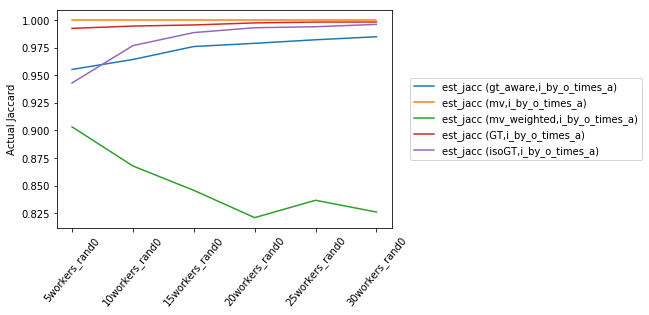

In [208]:
Nworker_performance = df.groupby("batch").mean().filter(regex="est_jacc").filter(regex="i_by_o_times_a")
Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in Nworker_performance.columns:
    plt.plot(np.array(Nworker_performance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Actual Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])

##### $\therefore$ Yes, most improve with Nworkers increase, except MV weighted 